**Chapter 18 – Reinforcement Learning**

_This notebook contains all the sample code in chapter 18_.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [47]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
    print("GPU was detected. Training will be faster.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [48]:
import gym

Let's list all the available environments:

In [49]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Using TF-Agents to Beat Breakout

Let's use TF-Agents to create an agent that will learn to play Breakout. We will use the Deep Q-Learning algorithm, so you can easily compare the components with the previous implementation, but TF-Agents implements many other (and more sophisticated) algorithms!

## TF-Agents Environments

In [50]:
tf.random.set_seed(42)
np.random.seed(42)

In [51]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [52]:
env.gym

In [53]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [54]:
env.step(1) # Fire

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

Saving figure breakout_plot


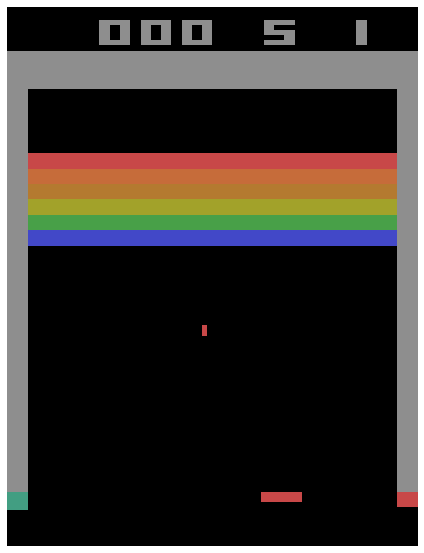

In [55]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [56]:
env.current_time_step()

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

## Environment Specifications

In [57]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [58]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [59]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

## Environment Wrappers

You can wrap a TF-Agents environments in a TF-Agents wrapper:

In [60]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [61]:
repeating_env.unwrapped

Here is the list of available wrappers:

In [62]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls to the given environment.
RunStats                    Wrapper that accumulates run statistics as the environment iterates.
TimeLimit      

The `suite_gym.load()` function can create an env and wrap it for you, both with TF-Agents environment wrappers and Gym environment wrappers (the latter are applied first).

In [63]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [64]:
limited_repeating_env

Create an Atari Breakout environment, and wrap it to apply the default Atari preprocessing steps:

In [65]:
limited_repeating_env.unwrapped

In [66]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

In [67]:
env

Play a few steps just to see what happens:

In [68]:
env.seed(42)
env.reset()
time_step = env.step(1) # FIRE
for _ in range(4):
    time_step = env.step(3) # LEFT

In [69]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure preprocessed_breakout_plot


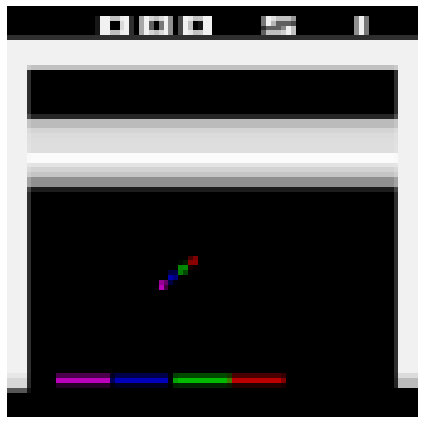

In [70]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

Convert the Python environment to a TF environment:

In [71]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## Creating the DQN

Create a small class to normalize the observations. Images are stored using bytes from 0 to 255 to use less RAM, but we want to pass floats from 0.0 to 1.0 to the neural network:

Create the Q-Network:

In [72]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

Create the DQN Agent:

In [73]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

# see TF-agents issue #113
#optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0,
#                                     epsilon=0.00001, centered=True)

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

Create the replay buffer:

In [74]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=1000000)

replay_buffer_observer = replay_buffer.add_batch

Create a simple custom observer that counts and displays the number of times it is called (except when it is passed a trajectory that represents the boundary between two episodes, as this does not count as a step):

In [75]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

Let's add some training metrics:

In [76]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [77]:
train_metrics[0].result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [78]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


Create the collect driver:

In [79]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

Collect the initial experiences, before training:

In [80]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

20000/20000

Let's sample 2 sub-episodes, with 3 time steps each and display them:

In [81]:
tf.random.set_seed(888) # chosen to show an example of trajectory at the end of an episode

trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)

In [82]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [83]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [84]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [85]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

Saving figure sub_episodes_plot


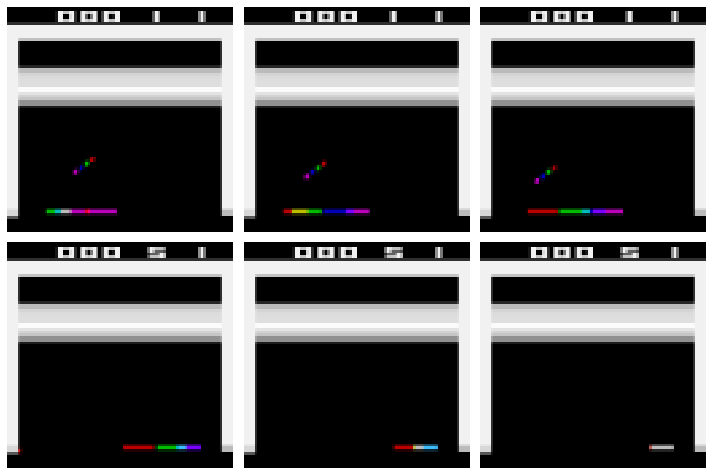

In [86]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

Now let's create the dataset:

In [87]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

Convert the main functions to TF Functions for better performance:

In [88]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

And now we are ready to run the main loop!

In [89]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

Run the next cell to train the agent for 10,000 steps. Then look at its behavior by running the following cell. You can run these two cells as many times as you wish. The agent will keep improving!

In [90]:
train_agent(n_iterations=1000000)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


998 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 4004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 169.39999389648438


1476 loss:0.00001

KeyboardInterrupt: 

In [ ]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(1)
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

If you want to save an animated GIF to show off your agent to your friends, here's one way to do it:

In [ ]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [ ]:
%%html
<img src="images/rl/breakout.gif" />